## 🔧 Step 1: Setup

In [ ]:
import numpy as np
import pandas as pd
from scipy.io import arff
import urllib.request
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Add, GlobalAveragePooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')

## 📦 Step 2: Load and Preprocess Data

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00327/Training%20Dataset.arff"
file_path, _ = urllib.request.urlretrieve(url)
data, meta = arff.loadarff(file_path)
df = pd.DataFrame(data)

str_df = df.select_dtypes([object]).applymap(lambda x: x.decode('utf-8'))
df[str_df.columns] = str_df

df['Result'] = df['Result'].replace({'1': 1, '-1': 0}).astype(int)
X = df.drop(columns='Result').values.astype(np.float32)
y = df['Result'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   having_IP_Address            11055 non-null  object
 1   URL_Length                   11055 non-null  object
 2   Shortining_Service           11055 non-null  object
 3   having_At_Symbol             11055 non-null  object
 4   double_slash_redirecting     11055 non-null  object
 5   Prefix_Suffix                11055 non-null  object
 6   having_Sub_Domain            11055 non-null  object
 7   SSLfinal_State               11055 non-null  object
 8   Domain_registeration_length  11055 non-null  object
 9   Favicon                      11055 non-null  object
 10  port                         11055 non-null  object
 11  HTTPS_token                  11055 non-null  object
 12  Request_URL                  11055 non-null  object
 13  URL_of_Anchor                11

In [ ]:
print("Number of features (excluding label):", df.shape[1] - 1)
print("Total columns (including label):", df.shape[1])


Number of features (excluding label): 30
Total columns (including label): 31


In [ ]:
print("Feature columns:")
print(df.columns[:-1].tolist())


Feature columns:
['having_IP_Address', 'URL_Length', 'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page', 'Statistical_report']


In [ ]:
print("Class distribution:")
print(df.iloc[:, -1].value_counts())  # last column assumed as label


Class distribution:
Result
1    6157
0    4898
Name: count, dtype: int64


In [ ]:
label_counts = df.iloc[:, -1].value_counts()
print(f"Phishing websites: {label_counts.get(1, 0)}")
print(f"Legitimate websites: {label_counts.get(0, 0)}")  # or 0, depending on dataset version


Phishing websites: 6157
Legitimate websites: 4898


## 🔁 Step 3: Data Augmentation

In [ ]:
def augment_data(X, noise_level=0.01):
    noise = np.random.normal(0, noise_level, X.shape)
    mask = np.random.binomial(1, 0.1, X.shape)
    return X + noise * mask

X_aug = augment_data(X)
y_aug = y.copy()
X_full = np.concatenate([X, X_aug], axis=0)
y_full = np.concatenate([y, y_aug], axis=0)

## 🔥 Step 4: Focal Loss

In [ ]:
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        return K.mean(weight * cross_entropy)
    return loss

## 🧠 Step 5: Residual Deep CNN

In [ ]:
def residual_block(x, filters, dropout_rate):
    shortcut = x

    # First Conv layer
    x = Conv1D(filters, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Second Conv layer
    x = Conv1D(filters, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(dropout_rate)(x)

    # Adjust shortcut if needed (channel mismatch)
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = Conv1D(filters, kernel_size=1, padding='same')(shortcut)

    return Add()([shortcut, x])


def build_deep_cnn(params, input_shape):
    filters = [int(round(p)) for p in params[:4]]
    dense_units = int(round(params[4]))
    dropout_rate = params[5]
    learning_rate = params[6]

    inp = Input(shape=input_shape)
    x = Conv1D(filters[0], 3, padding='same', activation='relu')(inp)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(dropout_rate)(x)

    for f in filters[1:]:
        x = residual_block(x, f, dropout_rate)

    x = GlobalAveragePooling1D()(x)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=focal_loss(),
                  metrics=['accuracy'])
    return model



## 🎯 Step 6: Fitness Function

In [ ]:
def fitness_function(params, X_train, y_train, X_val, y_val):
    params = np.clip(params, [16]*4 + [32, 0.1, 1e-5], [256]*4 + [512, 0.6, 1e-2])
    model = build_deep_cnn(params, X_train.shape[1:])
    early = EarlyStopping(patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(patience=3)
    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=25, batch_size=64, verbose=0,
              callbacks=[early, reduce_lr])
    preds = (model.predict(X_val) > 0.5).astype(int)
    return f1_score(y_val, preds)

## 🦅 Step 7: HHO Optimizer

In [ ]:
def hho_optimizer(fitness_func, X_data, y_data, n_hawks=10, max_iter=10):
    lb = np.array([16, 16, 16, 16, 32, 0.1, 1e-5])
    ub = np.array([256, 256, 256, 256, 512, 0.6, 1e-2])
    hawks = np.random.uniform(lb, ub, (n_hawks, len(lb)))
    rabbit = (None, -np.inf)
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, stratify=y_data)
    for iter in range(max_iter):
        for i in range(n_hawks):
            fitness = fitness_func(hawks[i], X_train, y_train, X_val, y_val)
            if fitness > rabbit[1]:
                rabbit = (hawks[i].copy(), fitness)
        E = 2 * (1 - iter / max_iter)
        for i in range(n_hawks):
            q, r = np.random.rand(2)
            if abs(E) >= 1:
                hawks[i] = hawks[np.random.randint(n_hawks)] - r * abs(hawks[np.random.randint(n_hawks)] - 2 * r * hawks[i])
            else:
                J = 2 * (1 - np.random.random())
                LF = 0.01 * np.random.standard_cauchy(size=len(lb))
                Y = rabbit[0] - E * abs(J * rabbit[0] - hawks[i])
                Z = Y + LF * (ub - lb)
                fit_Y = fitness_func(Y, X_train, y_train, X_val, y_val)
                fit_Z = fitness_func(Z, X_train, y_train, X_val, y_val)
                hawks[i] = Y if fit_Y > fit_Z else Z
            hawks[i] = np.clip(hawks[i], lb, ub)
        print(f"[HHO] Iter {iter+1}/{max_iter} - Best F1: {rabbit[1]:.4f}")
    return rabbit[0]

## 🚀 Step 8: Final Ensemble Training

In [ ]:
def lr_warmup(epoch, lr):
    warmup_epochs = 5
    if epoch < warmup_epochs:
        return lr * (epoch + 1) / warmup_epochs
    return lr

print("🔧 Running HHO Optimization...")
best_params = hho_optimizer(fitness_function, X_full, y_full, max_iter=10)
print("Best Params:", best_params)

models = []
for i in range(3):
    model = build_deep_cnn(best_params, X.shape[1:])
    model.fit(X_full, y_full, epochs=30, batch_size=64, validation_split=0.1,
              callbacks=[EarlyStopping(patience=10, restore_best_weights=True),
                         ReduceLROnPlateau(patience=5),
                         LearningRateScheduler(lr_warmup)],
              verbose=0)
    models.append(model)

test_preds = np.mean([m.predict(X) for m in models], axis=0).ravel()
final_preds = (test_preds > 0.5).astype(int)

print("\n📊 Final Results:")
print(f"Accuracy: {accuracy_score(y, final_preds):.4f}")
print(f"F1-Score: {f1_score(y, final_preds):.4f}")
print(f"AUC-ROC: {roc_auc_score(y, test_preds):.4f}")
print("\nClassification Report:\n", classification_report(y, final_preds))

🔧 Running HHO Optimization...
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
[HHO] Iter 1/10 - Best F1: 0.9678
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
[HHO] Iter 2/10 - Best F1: 0.9684
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 

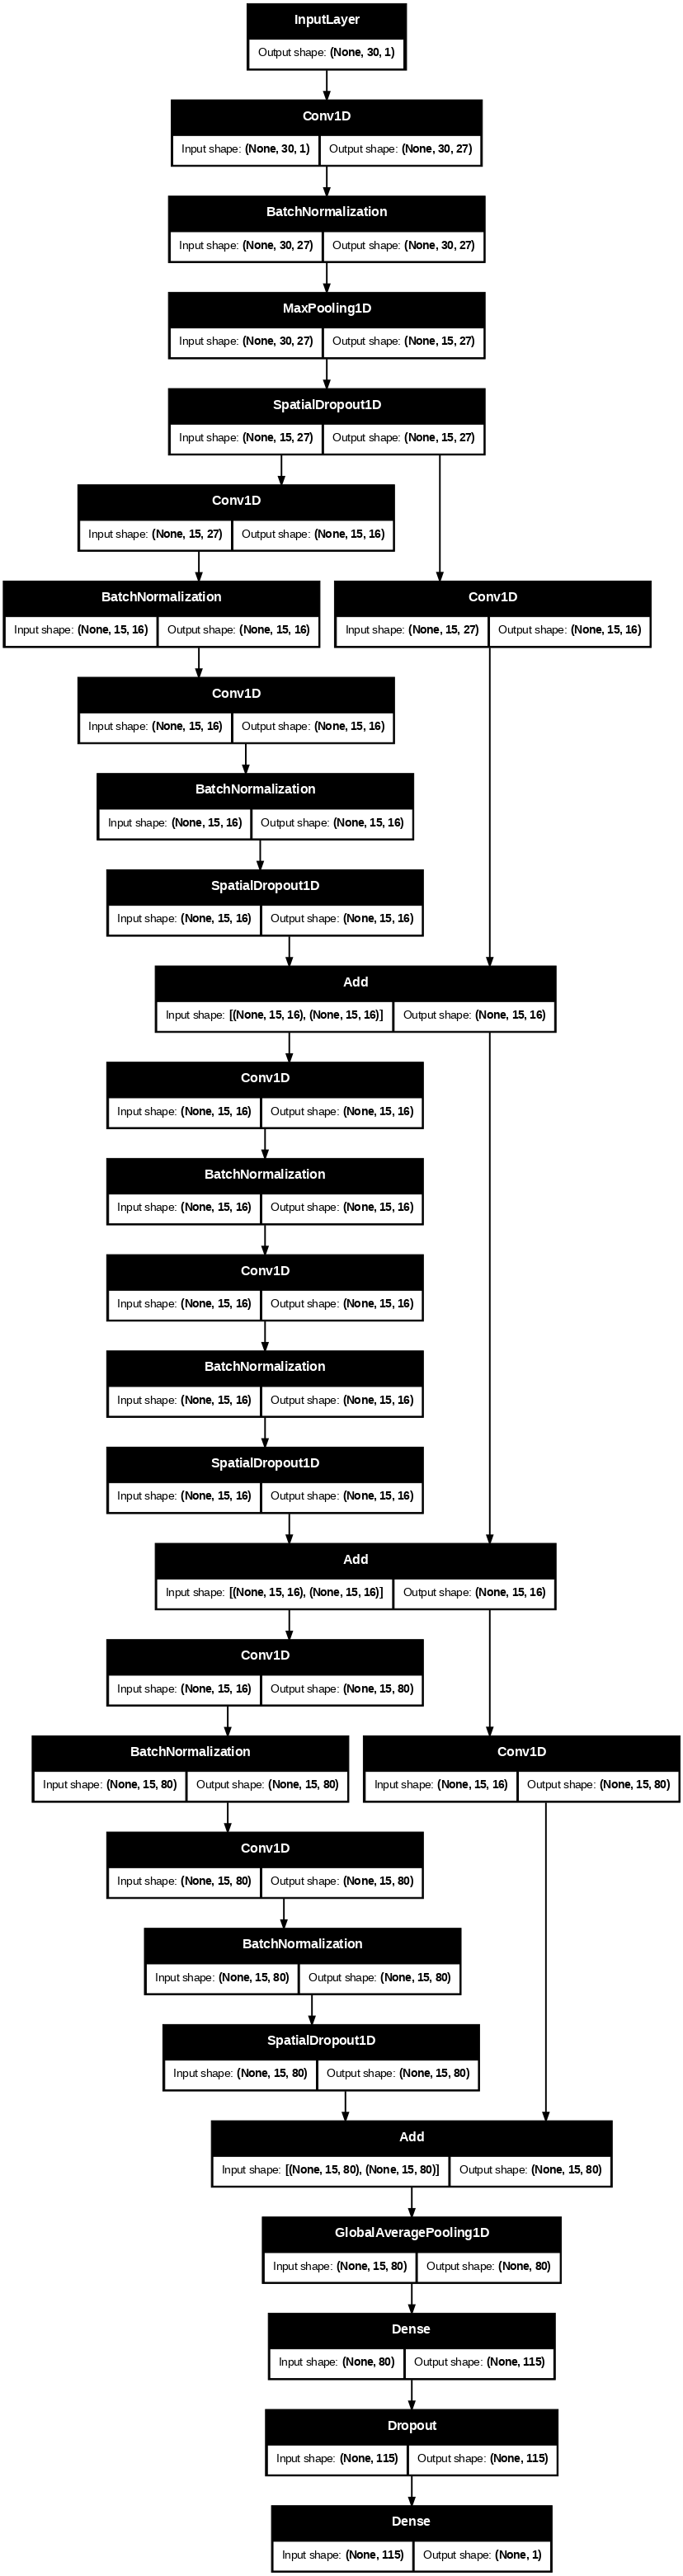

In [ ]:
from tensorflow import keras
#keras.utils.plot_model(model, show_shapes=True)
keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    dpi=70,
    rankdir='TB'  # 'LR' = left to right, 'TB' = top to bottom
)


In [ ]:
num_layers = len(model.layers)
print(f"Total number of layers: {num_layers}")


Total number of layers: 29


In [ ]:
from collections import Counter

layer_types = [type(layer).__name__ for layer in model.layers]
layer_counts = Counter(layer_types)

for layer_type, count in layer_counts.items():
    print(f"{layer_type}: {count}")


InputLayer: 1
Conv1D: 9
BatchNormalization: 7
MaxPooling1D: 1
SpatialDropout1D: 4
Add: 3
GlobalAveragePooling1D: 1
Dense: 2
Dropout: 1


In [ ]:
for layer in model.layers:
    print(layer.name)


input_layer_181
conv1d_1604
batch_normalization_1263
max_pooling1d_181
spatial_dropout1d_722
conv1d_1605
batch_normalization_1264
conv1d_1606
batch_normalization_1265
conv1d_1607
spatial_dropout1d_723
add_541
conv1d_1608
batch_normalization_1266
conv1d_1609
batch_normalization_1267
spatial_dropout1d_724
add_542
conv1d_1610
batch_normalization_1268
conv1d_1611
batch_normalization_1269
conv1d_1612
spatial_dropout1d_725
add_543
global_average_pooling1d_180
dense_360
dropout_180
dense_361


In [ ]:
model.summary()

Model: "functional_180"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_181     │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1604         │ (None, 30, 27)    │        108 │ input_layer_181[… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 27)    │        108 │ conv1d_1604[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_181   │ (None, 15, 27)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 15, 27)    │          0 │ max_pooling1d_18… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1605         │ (None, 15, 16)    │      1,312 │ spatial_dropout1… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 16)    │         64 │ conv1d_1605[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1606         │ (None, 15, 16)    │        784 │ batch_normalizat… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 16)    │         64 │ conv1d_1606[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1607         │ (None, 15, 16)    │        448 │ spatial_dropout1… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 15, 16)    │          0 │ batch_normalizat… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_541 (Add)       │ (None, 15, 16)    │          0 │ conv1d_1607[0][0… │
│                     │                   │            │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1608         │ (None, 15, 16)    │        784 │ add_541[0][0]     │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 16)    │         64 │ conv1d_1608[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1609         │ (None, 15, 16)    │        784 │ batch_normalizat… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 16)    │         64 │ conv1d_1609[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 15, 16)    │          0 │ batch_normalizat

 Total params: 116,643 (455.64 KB)

 Trainable params: 38,713 (151.22 KB)

 Non-trainable params: 502 (1.96 KB)

 Optimizer params: 77,428 (302.46 KB)

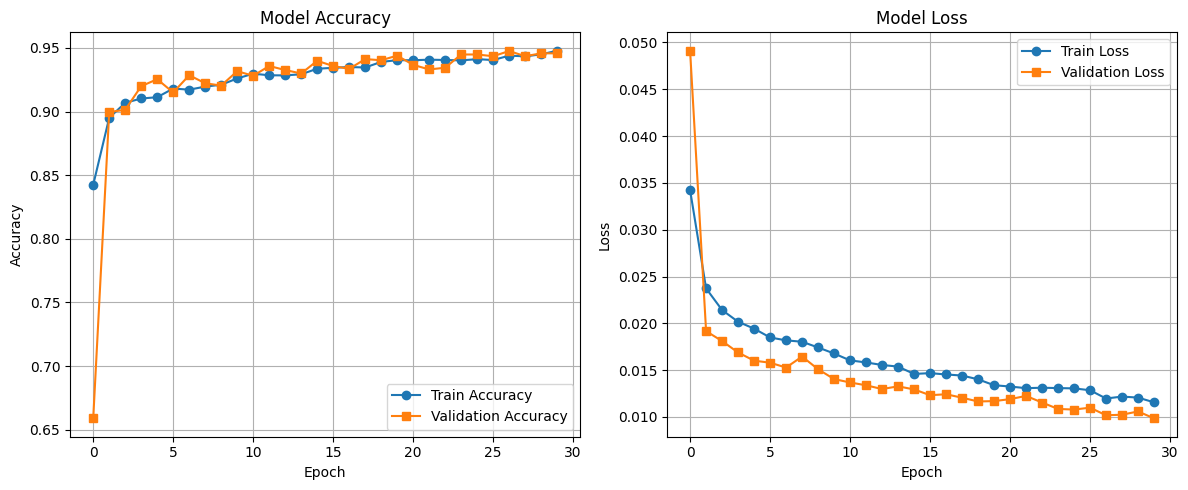

In [ ]:
# --- Accuracy and Loss Curves for one of the models (use first ensemble member) ---
model = models[0]
history = model.history

# NOTE: If model.history is not accessible, you need to store it manually during training.

# Simulated fallback if not available:
# history = model.fit(..., return value)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='s')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='s')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

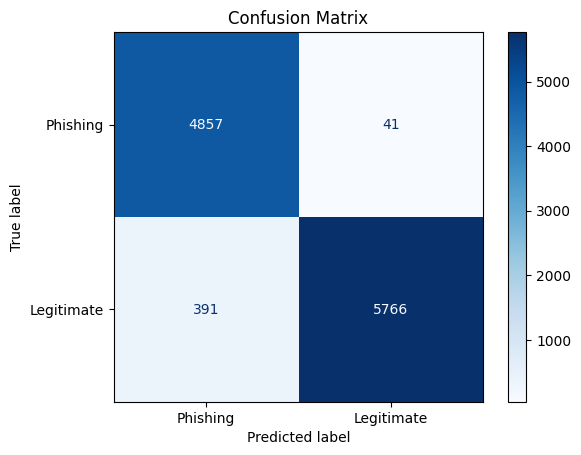

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Confusion Matrix ---
cm = confusion_matrix(y, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Phishing", "Legitimate"])

plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


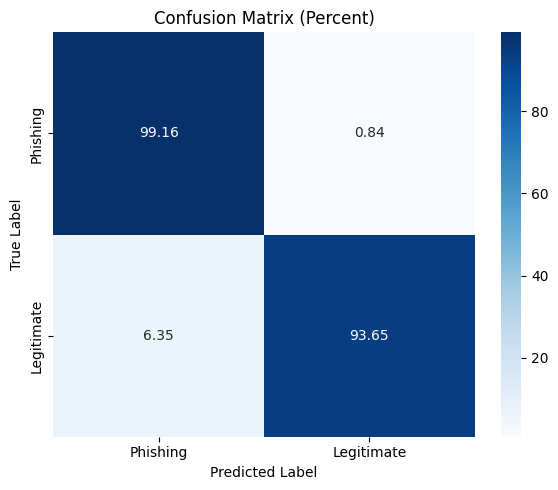

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y, final_preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["Phishing", "Legitimate"],
            yticklabels=["Phishing", "Legitimate"])

plt.title("Confusion Matrix (Percent)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


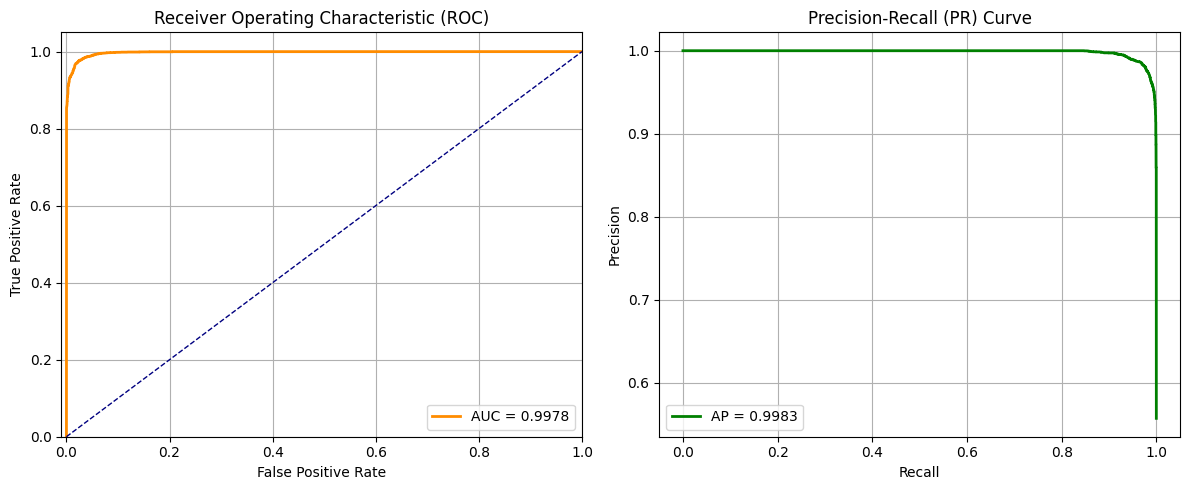

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# If you already have predictions:
# test_preds = np.mean([m.predict(X) for m in models], axis=0).ravel()
# final_preds = (test_preds > 0.5).astype(int)

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y, test_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y, test_preds)
ap_score = average_precision_score(y, test_preds)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label=f"AP = {ap_score:.4f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc='lower left')
plt.grid(True)

plt.tight_layout()
plt.show()


<div dir="rtl">

# رسم نمودار مقایسه‌ای چهار معیار اصلی

<div dir="rtl">

# 🔎 این نمودار عملکرد مدل تشخیص فیشینگ شما را در ۵ معیار اصلی مقایسه می‌کند:

# <div dir="rtl">   Accuracy: دقت کلی پیش‌بینی‌ها

# <div dir="rtl">   Precision: چند درصد پیش‌بینی‌های فیشینگ، واقعاً فیشینگ بودند

# <div dir="rtl">   Recall: چند درصد از کل فیشینگ‌ها به‌درستی شناسایی شدند

# <div dir="rtl">   F1-Score: میانگین متوازن بین precision و recall

# <div dir="rtl">   AUC-ROC: توانایی مدل در تفکیک بین دو کلاس در تمام آستانه‌ها

</div>

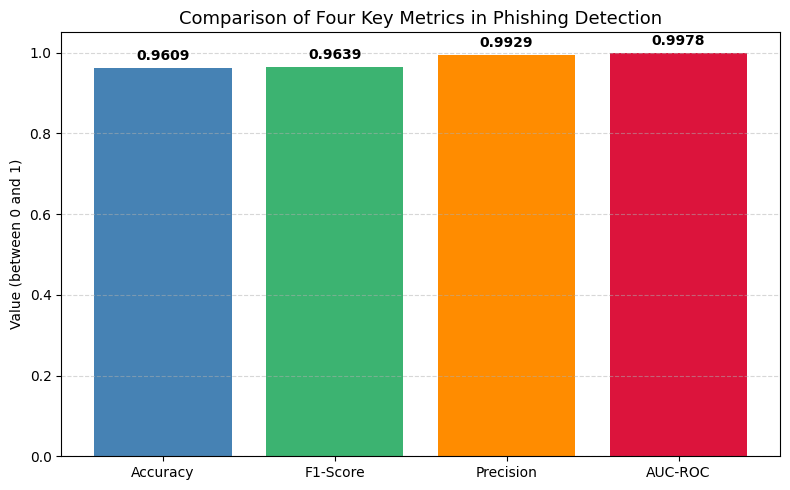

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# فرض: y (برچسب‌های واقعی) و test_preds (احتمالات خروجی مدل) و final_preds (پیش‌بینی نهایی باینری) را قبلاً محاسبه کردی

# محاسبه چهار معیار اصلی
acc = accuracy_score(y, final_preds)
f1 = f1_score(y, final_preds)
prec = precision_score(y, final_preds)
#recall = recall_score(y, final_preds)
auc = roc_auc_score(y, test_preds)


# ساخت دیکشنری معیارها
metrics = {
    'Accuracy': acc,
    'F1-Score': f1,
    'Precision': prec,
    'AUC-ROC': auc,
    #'Recall' : recall
}

# رسم نمودار
plt.figure(figsize=(8, 5))
colors = ['steelblue', 'mediumseagreen', 'darkorange', 'crimson']
bars = plt.bar(metrics.keys(), metrics.values(), color=colors)

# افزودن مقدار عددی بالای هر ستون
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 4), textcoords='offset points',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# عنوان و تنظیمات نمودار
plt.title('Comparison of Four Key Metrics in Phishing Detection', fontsize=13)
plt.ylim(0, 1.05)
plt.ylabel('Value (between 0 and 1)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
